In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%cd /content/drive/My\ Drive/Mask_RCNN

/content/drive/My Drive/Mask_RCNN


In [ ]:
!pwd

/content/drive/My Drive/Mask_RCNN


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN


class helmetDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "helmet")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 1900 if we are building the train set
			if is_train and int(image_id) >= 1900:
				continue
			# skip all images before 1900 if we are building the test/val set
			if not is_train and int(image_id) < 1900:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('helmet'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# define a configuration for the model
class KangarooConfig(Config):
	# define the name of the configuration
	NAME = "helmet_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 800

# prepare train set
train_set = helmetDataset()
train_set.load_dataset('helmet', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = helmetDataset()
test_set.load_dataset('helmet', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = KangarooConfig()
config.display()
# define the model
#model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
#model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
#model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=15, layers='heads')

Using TensorFlow backend.


Train: 1899
Test: 1101

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

In [ ]:

from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset

# class that defines and loads the kangaroo dataset

	

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "helmet_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

def plot_actual_vs_predicted(dataset, model, cfg, n_images=4):
	# load image and mask
	for i in range(10):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0] # BAsically this is the part which runs the model on the picture 
		
	
		
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(10, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

# load the train dataset
train_set = helmetDataset()
train_set.load_dataset('helmet', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = helmetDataset()
test_set.load_dataset('helmet', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_helmet_cfg_0015.h5'
model.load_weights(model_path, by_name=True)

#plot_actual_vs_predicted(test_set, model, cfg)

Train: 1899
Test: 1101
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
train_set = helmetDataset()
train_set.load_dataset('helmet', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = helmetDataset()
test_set.load_dataset('helmet', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config

Train: 1899
Test: 1101


In [ ]:
image = test_set.load_image(10)

In [ ]:
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_helmet_cfg_0015.h5'
model.load_weights(model_path, by_name=True)

In [ ]:
# this is one of the method to use the model
#But in this I am only able to test the model on images which are in the data set aka the test_set,
# but i am not able to take anu other image, as the 
# scaled_image and sample are not running on it
image_id = random.choice(test_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))

scaled_image = mold_image(image, cfg)
sample = expand_dims(scaled_image, 0)

image ID: dataset.002326 (47) helmet/images/002326.jpg


[[ 327  460  417  534]
 [ 368  384  444  441]
 [ 349  212  437  286]
 [ 327  903  416  971]
 [ 345  686  424  744]
 [ 359  119  423  170]
 [ 380  175  452  228]
 [ 364  870  417  912]
 [ 360  799  408  835]
 [ 343  520  419  562]
 [ 349  964  418 1012]]


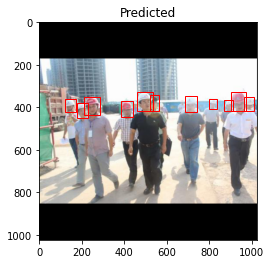

In [ ]:
#In this we are just making the Bounding boxes on the 
# random image whcih comes from the test_set
yhat = model.detect(sample, verbose=0)[0]
print(yhat['rois'])
pyplot.imshow(image)
pyplot.title('Predicted')
ax = pyplot.gca()
for box in yhat['rois']:
  y1, x1, y2, x2 = box
  width1 = x2 - x1
  height = y2 - y1
  rect = Rectangle((x1, y1), width1, height, fill=False, color='red')
  ax.add_patch(rect)
pyplot.show()

  
  

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (168, 299, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (14,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (14, 4)               min:  116.00000  max: 1020.00000  int32
gt_mask                  shape: (1024, 1024, 14)      min:    0.00000  max:    1.00000  uint8


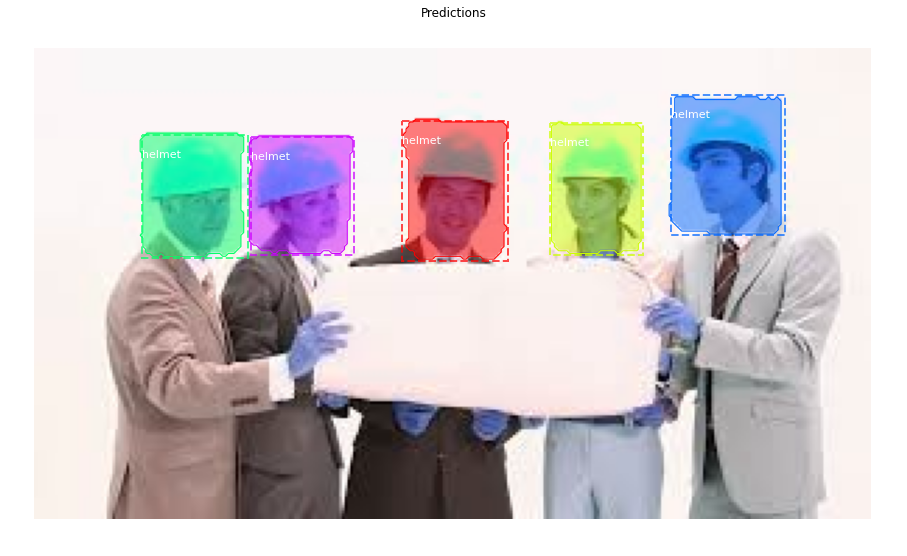

In [ ]:
#The other method to get the images masked
import numpy as np
import cv2
img = cv2.imread('helmets.jfif')
results = model.detect([img], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names,ax=ax, show_mask="False", figsize=(320,240),
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)